# Newer Scoring system

The csv file of picks must:

    1- have Results as the first row 
    
    2- have games as either 'n Games' or '- Games' where n is an integer

## Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# set font to look like Latex
font = {'family' : 'serif',
        'size'   : 12}
mpl.rc('font', **font)

In [2]:
year = 2019
#os.chdir('./'+str(year)+'/')

## Define Functions

In [3]:
## Plotting functions
def add_legend(ax, axis_bar):
    # Shrink current axis by 25%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

    # remove unused elements of a_bar
    a_bar2 = list(filter(lambda a: a != 0, axis_bar))

    # Put a legend to the right of the current axis
    plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))

def save_figure(plt, data):
    #os.chdir('Figures')
    filename = data.name
    form = 'pdf'
    plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
    form = 'png'
    plt.savefig(filename+'.'+form, bbox_inches='tight', format=form, dpi=300)
    #os.chdir('..')

In [4]:
def make_plot(data, save=False, text=True, legend=True):
    # data:   the table of everyone's points per round/SC
    # save:   save the figure?
    # text:   add text values over bars?
    # legend: add the legend?
    
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Conference']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = 0
        for ind in range(len(widths)):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if w != 0:
                    if text:
                        ax.text(x, y, "%d" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-1:
                # add total sum of points outside bar graph
                x = bl[0] + patch.get_width() + np.max(df.max())/10
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    ax.text(x, y, "%d" % (total), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlim(0,data.sum().max()*1.01)
    plt.title(data.name)

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        add_legend(ax, a_bar)
    if save:
        save_figure(plt, data)
    
    # display plot inline
    plt.show();

In [5]:
def read_round(year, rnd):
    # adjust for Stanley cup (the finals) picks
    rnd_orig = rnd
    if rnd == 'SC':
        rnd_orig = 'SC'
        rnd = 1

    fname = str(year)+' Friendly Playoff Pool Round '+str(rnd)+'.csv'    # read file
    if os.path.isfile(fname):    
        # if file exists, return a pandas table
        fdata = pd.read_csv(fname, sep=',')
        
        # make the names of people the index (the row name)
        fdata.index = fdata['Name:']

        # over write the column headers
        header = fdata.columns.values
        if rnd == 1:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','WCC','ECC','SCC']
        elif rnd == 2:
            header[2:] = ['T1','G1','P1','T2','G2','P2','T3','G3','P3','T4','G4','P4']
        elif rnd == 3:
            header[2:] = ['T1','G1','P1','T2','G2','P2','Q1']
        elif rnd == 4:
            header[2:] = ['T1','G1','P1','Q1']
        fdata.columns = header

        # Remove 'Games' in games columns and cast numbers to integer
        N_series = 2**(4-rnd)      # number of series in round
        for ind in ['G'+str(x) for x in range(1,N_series+1)]:
            if fdata[ind].values[0] == '- Games':
                # set to an integer because arithmetic won't work later (a python thing)
                fdata[ind].values[0] = '0 Games'
            # remove and cast
            fdata[ind] = fdata[ind].map(lambda x: x.rstrip(' Games')).astype(int)
    else:
        # if file does NOT exists, return a string
        fdata = '-'
    
    if rnd_orig == 'SC':
        fdata = fdata.loc[:,['Name:','WCC','ECC','SCC']]
    return fdata

In [12]:
def get_round_points(year, rnd):
    # get table of results for the particular round
    df = read_round(year, rnd)
    
    # Points:
    SC_points = 20 # for ECC, WCC, and SCC
    player_points = 10
    overtime_points = 10
    overtime_1off_points = 5
    
    # calculate points if predictions have been made for this round
    if not isinstance(df, str):
        N_people = df.shape[0]-1
        pts = [0]*N_people
        
        if rnd == 'SC':
            # If the 'round' is the Stanley Cup and Conference champions
            team_actual = df.iloc[0].values
            for ind in range(1,N_people+1):
                team_pick = df.iloc[ind].values
                rnd3_started = os.path.isfile(str(year)+' Friendly Playoff Pool Round 3.csv')
                if rnd3_started:
                    pts[ind-1] = np.where(team_actual == team_pick, SC_points, 0).sum()
                else:
                    pts[ind-1] = np.where(team_actual == team_pick, SC_points, np.NaN).sum()
        else:
            N_series = 2**(4-rnd)      # number of series in round
            
            # get actual results for each series
            team_start_col = 2
            game_start_col = 3
            plyr_start_col = 4
            if rnd == 1:
                picks_per_series = 2
            elif rnd >= 2:
                picks_per_series = 3
            last_pick_col = picks_per_series*N_series + 2;
            team_cols = range(team_start_col, last_pick_col, picks_per_series)  # columns of team picks
            game_cols = range(game_start_col, last_pick_col, picks_per_series)  # columns of game picks
            team_actual = df.iloc[0].values[team_cols]
            game_actual = df.iloc[0].values[game_cols]
            if rnd > 1:
                plyr_cols = range(plyr_start_col, last_pick_col, picks_per_series)  # columns of game picks
                plyr_actual = df.iloc[0].values[plyr_cols]
            if rnd > 2:
                overtime_col = -1;
                overtime_actual = int(df.iloc[0].values[overtime_col])
                
            # get an individual's picks for each series
            for ind in range(1,N_people+1):
                # find the individual's picks
                team_pick = df.iloc[ind].values[team_cols]
                game_pick = df.iloc[ind].values[game_cols]
                if rnd > 1:
                    plyr_pick = df.iloc[ind].values[plyr_cols]
                    
                # Points equations
                series_correct_points   = 15 - 2*np.abs(game_pick - game_actual)
                series_incorrect_points = -8 + game_pick + game_actual
                # calculate the individuals points
                pts[ind-1] = np.where(pd.isnull(team_actual),0,
                                      np.where(team_actual == team_pick,
                        series_correct_points, series_incorrect_points)).sum()
                
            # add points for Player picks
            if rnd > 1:
                for ind in range(1,N_people+1):
                    # find the individual's picks
                    plyr_pick = df.iloc[ind].values[plyr_cols]
                    pts[ind-1] = pts[ind-1] + np.where(plyr_actual == plyr_pick,
                                                      player_points, 0).sum()
            # add points for overtime pick
            if rnd > 2:
                for ind in range(1,N_people+1):
                    # find the individual's pick
                    overtime_pick = df.iloc[ind].values[overtime_col]
                    # adjust and set to interger type
                    if overtime_pick == 'More than 3':
                        overtime_pick = '4'
                    overtime_pick = int(overtime_pick)
                    # add to the points
                    if overtime_actual == overtime_pick:
                        pts[ind-1] = pts[ind-1] + overtime_points
                    elif np.abs(overtime_actual - overtime_pick) == 1:
                        pts[ind-1] = pts[ind-1] + overtime_1off_points

        # add the a new table
        ser = pd.Series(pts, index=df['Name:'].values[1:])
    else:
        ser = '-'
    return ser

In [13]:
def get_year_table(year):
    # get points for all people in all rounds
    r1 = get_round_points(year, 1)
    r2 = get_round_points(year, 2)
    r3 = get_round_points(year, 3)
    r4 = get_round_points(year, 4)
    SC = get_round_points(year, 'SC')
    
    # create lists of people who participated in each round
    r1names = r1.index.values
    if not isinstance(r2, str):
        r2names = r2.index.values
    else:
        r2names = '-'
    if not isinstance(r3, str):
        r3names = r3.index.values
    else:
        r3names = '-'
    if not isinstance(r4, str):
        r4names = r4.index.values
    else:
        r4names = '-'
        
    # create a list of all the people who participated in the year
    all_names = r1names
    # compare round 2 to round 1
    if not isinstance(r2, str):
        diff = np.setdiff1d(r2names,all_names)
        all_names = np.append(all_names,diff)
    # compare round 3 to round 1 and 2
    if not isinstance(r3, str):
        diff = np.setdiff1d(r3names,all_names)
        all_names = np.append(all_names,diff)
    # compare round 4 to round 1 and 2 and 3
    if not isinstance(r4, str):
        diff = np.setdiff1d(r4names,all_names)
        all_names = np.append(all_names,diff)
    all_names = np.sort(all_names)
    
    # put all people into each round
    pts1  = [0]*all_names.size
    pts2  = [0]*all_names.size
    pts3  = [0]*all_names.size
    pts4  = [0]*all_names.size
    ptsSC = [0]*all_names.size
    ind = 0
    for name in all_names:
        # Round 1 points
        if name in r1names:
            pts1[ind] = r1[name]
        else:
            pts1[ind] = np.NaN
        # Round 2 points
        if name in r2names:
            pts2[ind] = r2[name]
        else:
            pts2[ind] = np.NaN
        # Round 3 points
        if name in r3names:
            pts3[ind] = r3[name]
        else:
            pts3[ind] = np.NaN
        # Round 4 points
        if name in r4names:
            pts4[ind] = r4[name]
        else:
            pts4[ind] = np.NaN
        # Stanley Cup round points
        if name in r1names:
            ptsSC[ind] = SC[name]
        else:
            ptsSC[ind] = np.NaN
        # increase the name index
        ind = ind+1
    
    # Put in a large table
    all_score = np.vstack((pts1,pts2,pts3,pts4,ptsSC))
    df = pd.DataFrame(all_score, index=['R1', 'R2', 'R3', 'R4', 'SC'])
    df.columns = all_names
    
    return df

## Make Plot

In [14]:
df = get_year_table(year)
df

,Alita,Andre,Andres,Andrew,Anthony,Brian,David,Jack,Jeremy,Jon,Josh,Kollin,Kyle,Mark,Michael,Nathan,Ron
R1,79.0,46.0,32.0,52.0,44.0,50.0,48.0,48.0,44.0,42.0,44.0,45.0,40.0,41.0,37.0,47.0,39.0
R2,50.0,64.0,45.0,32.0,52.0,32.0,31.0,66.0,35.0,44.0,34.0,53.0,44.0,62.0,41.0,52.0,NaN
R3,43.0,26.0,15.0,NaN,11.0,30.0,32.0,6.0,23.0,16.0,12.0,12.0,5.0,28.0,15.0,16.0,NaN
R4,18.0,14.0,NaN,NaN,33.0,14.0,31.0,15.0,10.0,10.0,23.0,28.0,28.0,16.0,NaN,28.0,NaN
SC,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0


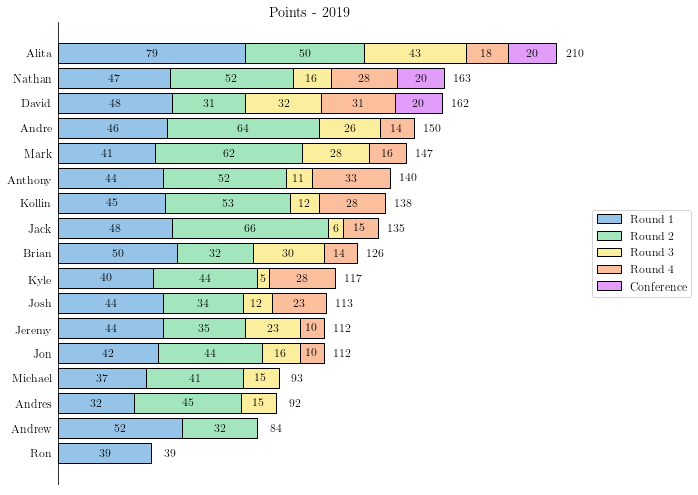

In [15]:
#make_plot(df, save=False, text=True, legend=True):
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(year)
#make_plot(df_sorted, save=False)
make_plot(df_sorted, save=True)

## Testing

In [20]:
df

,Alita,Andre,Andres,Andrew,Anthony,Brian,David,Jack,Jeremy,Jon,Josh,Kollin,Kyle,Mark,Michael,Nathan,Ron
R1,79.0,46.0,32.0,52.0,44.0,50.0,48.0,48.0,44.0,42.0,44.0,45.0,40.0,41.0,37.0,47.0,39.0
R2,50.0,64.0,45.0,32.0,52.0,32.0,31.0,66.0,35.0,44.0,34.0,53.0,44.0,62.0,41.0,52.0,NaN
R3,43.0,26.0,15.0,NaN,11.0,30.0,32.0,6.0,23.0,16.0,12.0,12.0,5.0,28.0,15.0,16.0,NaN
R4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SC,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0


In [27]:
df.loc['R1'].sum()/17

45.764705882352942

In [28]:
df.loc['R2'].sum()/16

46.0625

In [29]:
df.loc['R3'].sum()/15

19.333333333333332